In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('Train_TEC_mar17.csv')

In [6]:
df.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


In [7]:
df.drop(["Date","Month","Year","Time","LT"], axis = 1, inplace = True)

In [8]:
df.head()

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503


In [16]:
training_set = df.iloc[:,:].values

In [17]:
training_set.shape

(14400, 1)

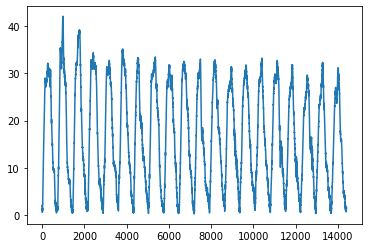

In [18]:
plt.plot(training_set, label = 'TEC Values')
plt.show()

In [19]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.90)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [20]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [23]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08479
Epoch: 1, loss: 0.07997
Epoch: 2, loss: 0.07595
Epoch: 3, loss: 0.07267
Epoch: 4, loss: 0.07008
Epoch: 5, loss: 0.06810
Epoch: 6, loss: 0.06667
Epoch: 7, loss: 0.06570
Epoch: 8, loss: 0.06510
Epoch: 9, loss: 0.06479
Epoch: 10, loss: 0.06466
Epoch: 11, loss: 0.06463
Epoch: 12, loss: 0.06464
Epoch: 13, loss: 0.06460
Epoch: 14, loss: 0.06449
Epoch: 15, loss: 0.06428
Epoch: 16, loss: 0.06395
Epoch: 17, loss: 0.06350
Epoch: 18, loss: 0.06295
Epoch: 19, loss: 0.06232
Epoch: 20, loss: 0.06161
Epoch: 21, loss: 0.06087
Epoch: 22, loss: 0.06009
Epoch: 23, loss: 0.05931
Epoch: 24, loss: 0.05852
Epoch: 25, loss: 0.05773
Epoch: 26, loss: 0.05693
Epoch: 27, loss: 0.05612
Epoch: 28, loss: 0.05528
Epoch: 29, loss: 0.05439
Epoch: 30, loss: 0.05344
Epoch: 31, loss: 0.05240
Epoch: 32, loss: 0.05127
Epoch: 33, loss: 0.05001
Epoch: 34, loss: 0.04864
Epoch: 35, loss: 0.04715
Epoch: 36, loss: 0.04554
Epoch: 37, loss: 0.04382
Epoch: 38, loss: 0.04199
Epoch: 39, loss: 0.04007
Epoch: 40,

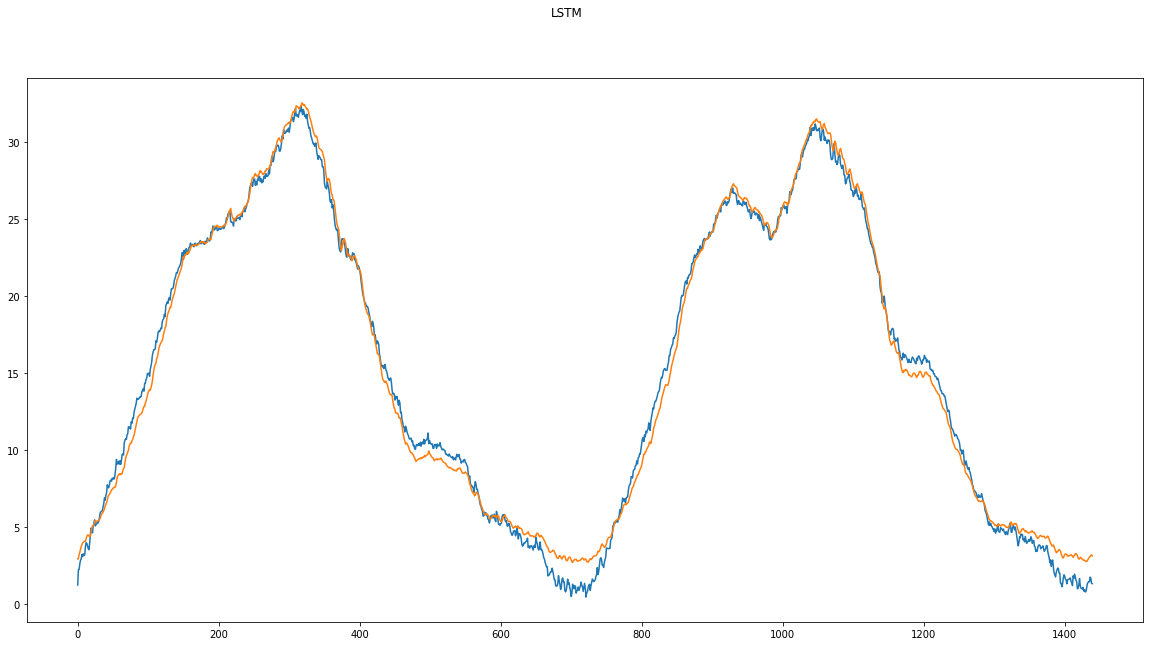

In [28]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[-1440:])
plt.plot(data_predict[-1440:])
plt.suptitle('LSTM')
plt.show()